In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Environment

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, n = 3, is_stochastic = False, random_start = False):
        self.observation_space = spaces.Discrete(n ** 2)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 3 * n + 1
        self.is_stochastic = is_stochastic
        self.n = n
        self.random_start = random_start

        # defining stochastic environment such that ∑P_i = 1
        if self.is_stochastic:
            self.transition_prob = []
            for i in range(n):
                x = []
                for j in range(n):
                    y = []
                    for action in range(self.action_space.n):
                        z = [.1] * self.action_space.n
                        z[action] = .7
                        y.append(z)
                        x.append(y)
                self.transition_prob.append(x)
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.zeros(2, dtype = int)
        if self.random_start:
            self.agent_pos = np.random.randint(self.n, size = 2)
        self.goal_pos = [self.n - 1, self.n - 1]
        self.monster_pos = [self.n // 2, self.n // 2]
        self.update_state()
        self.prev_distance = self.get_distance(self.agent_pos, self.goal_pos)
        observation = self.agent_pos
        return self.createState(observation)
    
    # creating state for neural network as per one hot encoding
    def createState(self, obs):
        one_hot = torch.zeros((1, self.observation_space.n), device = device)
        one_hot[0, (self.n * obs[0]) + obs[1]] = 1
        return one_hot

    def update_state(self):
      self.state = np.zeros((self.n, self.n))
      self.state[tuple(self.goal_pos)] = 0.5
      self.state[tuple(self.monster_pos)] = 0.25
      self.state[tuple(self.agent_pos)] = 1

    def get_action(self, x, y, action):
        return np.random.choice(self.action_space.n, p = self.transition_prob[x][y][action])

    def get_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        if self.is_stochastic:
            action = self.get_action(self.agent_pos[0], self.agent_pos[1], action)

        # top-left: (0, 0)
        if action == 0: #down
            self.agent_pos[0] += 1
        if action == 1: #up
            self.agent_pos[0] -= 1
        if action == 2: #right
            self.agent_pos[1] += 1
        if action == 3: #left
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.n - 1)
        self.update_state()
        observation = self.agent_pos
        
        reward = 0
        current_distance = self.get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        else:
            reward = -1
        self.prev_distance = current_distance

        goal_reached = (self.agent_pos == self.goal_pos).all()
        if goal_reached:
            reward = 10

        found_monster = (self.agent_pos == self.monster_pos).all()
        if found_monster:
            reward = -10
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or goal_reached or found_monster else False
        info = {}
        
        return self.createState(observation), reward, done, info
        
    def render(self):
        plt.imshow(self.state)
        plt.show()

### Agent

In [ ]:
class DQN(nn.Module):
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
  

In [ ]:
from collections import deque, namedtuple
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque()

    def push(self, *args):
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
            self.memory.popleft()

    def sample(self, batch_size):
        idx = np.random.choice(len(self.memory), batch_size)
        return np.array(self.memory)[idx]

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN_Agent:
    def __init__(self, env, epsilon = 1.0, lr = 0.001, gamma = 0.999, bufferSize = 2000):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.epsilon = epsilon
        self.gamma = gamma
        self.online_net = DQN(self.observation_space.n, self.action_space.n).to(device)
        self.target_net = DQN(self.observation_space.n, self.action_space.n).to(device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.online_net.parameters(), lr = lr)
        self.criterion = nn.MSELoss()
        self.memory = ReplayMemory(bufferSize)

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def step(self, state):
        if np.random.random() < self.epsilon:
            return torch.tensor([[np.random.choice(self.action_space.n)]], device = device, dtype = torch.long)
        else:
            with torch.no_grad():
                return self.online_net(state).max(1)[1].view(1, 1)

    def populateReplayMemory(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)
    
    # ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    def train(self, batch_size = 128):
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device, dtype = torch.bool)
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state = torch.cat(batch.state)
        action = torch.cat(batch.action)
        reward = torch.cat(batch.reward)

        state_action_values = self.online_net(state).gather(1, action)

        next_state_values = torch.zeros(batch_size, device = device)
        next_state_values[non_terminal_mask] = self.target_net(non_terminal_next_states).max(1)[0].detach()
        
        expected_state_action_values = (next_state_values * self.gamma) + reward

        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # train the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.online_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def updateWeights(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def test(self):
        state = self.env.reset()
        done = False
        self.epsilon = 0
        self.env.render()
        while not done:
            action = self.step(state)
            obs, reward, done, info = self.env.step(action)
            state = obs
            self.env.render()

### MDP

In [ ]:
def MDP(episodes, n = 5, isStochastic = False, randomStart = False, epsilon = 1.0, lr = 0.001, gamma = 0.999, bufferSize = 2000):
    env = GridEnvironment(n, is_stochastic = isStochastic, random_start = randomStart)
    agent = DQN_Agent(env, epsilon = epsilon, lr = lr, gamma = gamma, bufferSize = bufferSize)

    target_update = 10
    steps = 0
    epsilon = agent.epsilon
    epsilons = []
    delta_epsilon = epsilon / episodes
    epsilons = [epsilon]
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        if episode > 0:
            epsilon = epsilon - (5 * epsilon * delta_epsilon)
            epsilons.append(epsilon)
            agent.set_epsilon(epsilon)
        
        curr_reward = 0
        i = 0
        while not done:
            action = agent.step(state)
            next_state, reward, done, info = env.step(action.item())
            curr_reward += reward
            reward = torch.tensor([reward], device = device)

            if done:
                next_state = None
                
            agent.populateReplayMemory(state, action, next_state, reward)

            state = next_state
            if i % 3 == 0:
                agent.train()
            i += 1
            steps += 1
            
        if episode % target_update == 0:
            agent.updateWeights()
        
        total_rewards.append(curr_reward)
        
        if (episode + 1) % 20 == 0:
            print(f'{episode + 1} episode completed.')

    print('Complete')
    print(f'On Average {steps / episodes} steps per episode\n')
    env.render()
    return env, agent, epsilons, total_rewards

In [ ]:
def plotGraphs(epsilons, total_rewards):
    # Plotting ε vs Episodes
    plt.figure(1)
    plt.title('Epsilon decay')
    plt.xlabel('Episodes')
    plt.ylabel('$\epsilon$')
    plt.plot(epsilons)

    # Plotting Total rewards received vs Episodes
    plt.figure(2)
    step = 10
    plt.title('Rewards dynamics')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward (SMA 10)')
    plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])


### Deterministic Environment

20 episode completed.
40 episode completed.
60 episode completed.
80 episode completed.
100 episode completed.
120 episode completed.
140 episode completed.
160 episode completed.
180 episode completed.
200 episode completed.
Complete
On Average 10.14 steps per episode



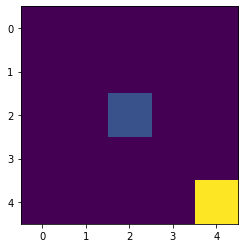

In [ ]:
env, agent, epsilons, total_rewards = MDP(200)

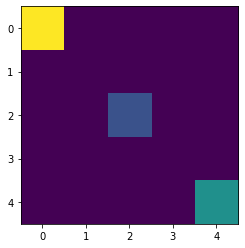

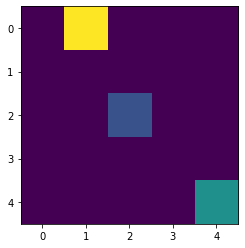

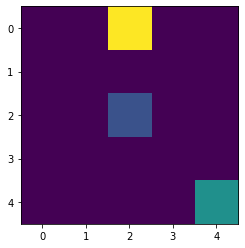

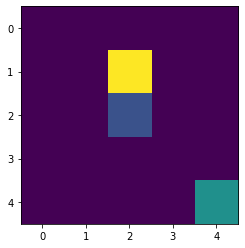

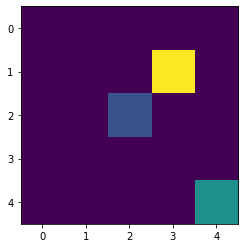

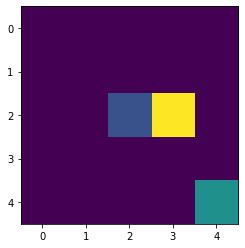

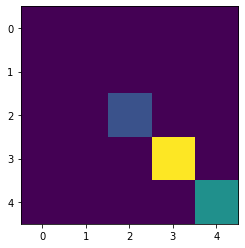

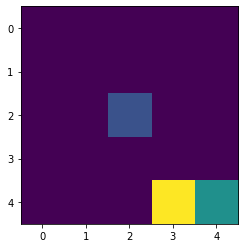

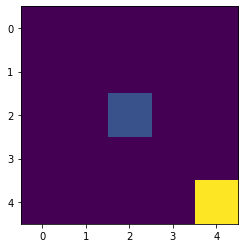

In [ ]:
agent.test()

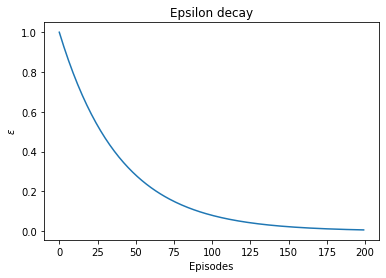

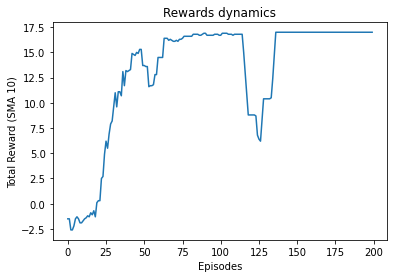

In [ ]:
plotGraphs(epsilons, total_rewards)

### Stochastic Environment

20 episode completed.
40 episode completed.
60 episode completed.
80 episode completed.
100 episode completed.
120 episode completed.
140 episode completed.
160 episode completed.
180 episode completed.
200 episode completed.
220 episode completed.
240 episode completed.
260 episode completed.
280 episode completed.
300 episode completed.
320 episode completed.
340 episode completed.
360 episode completed.
380 episode completed.
400 episode completed.
420 episode completed.
440 episode completed.
460 episode completed.
480 episode completed.
500 episode completed.
520 episode completed.
540 episode completed.
560 episode completed.
580 episode completed.
600 episode completed.
Complete
On Average 13.111666666666666 steps per episode



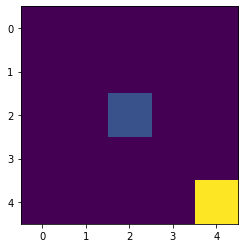

In [ ]:
env1, agent1, epsilons1, total_rewards1 = MDP(600, isStochastic = True)

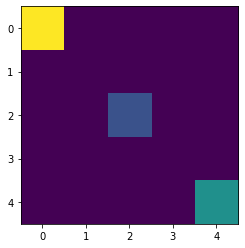

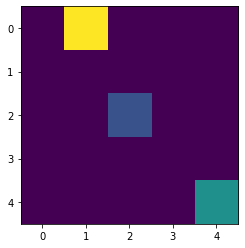

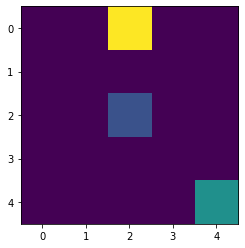

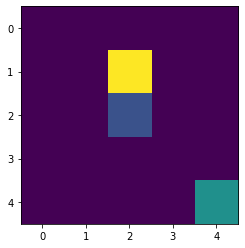

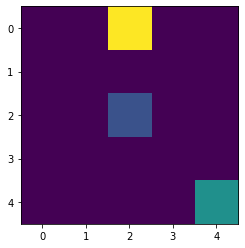

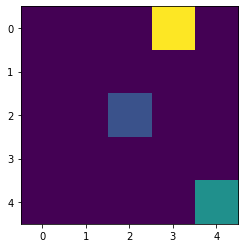

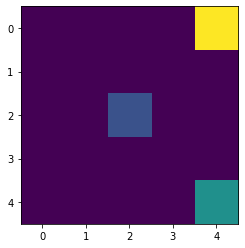

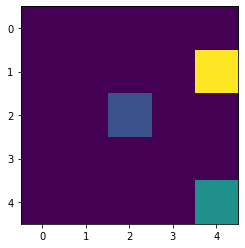

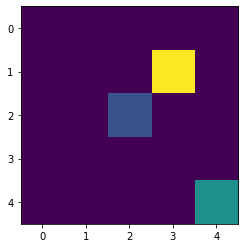

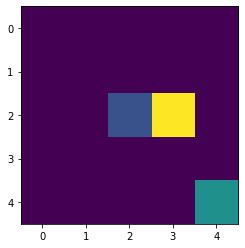

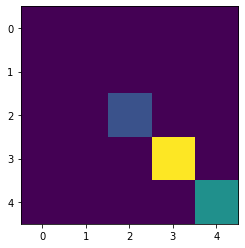

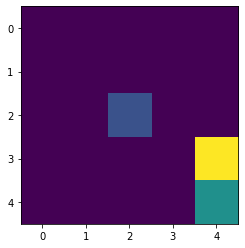

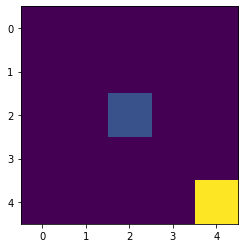

In [ ]:
agent1.test()

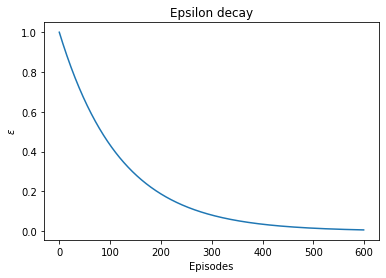

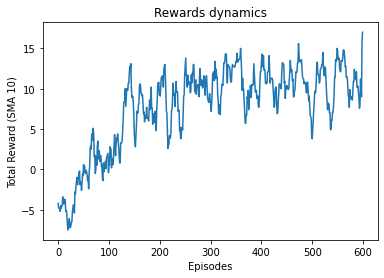

In [ ]:
plotGraphs(epsilons1, total_rewards1)

In [ ]:
import pickle

with open('DQN_grid_det.pkl', 'wb') as f:
    pickle.dump(total_rewards, f)

with open('DQN_grid_stoc.pkl', 'wb') as f:
    pickle.dump(total_rewards1, f)
